Install the Libraries first:

In [ ]:
!pip install ucimlrepo
!pip install imbalanced-learn

Tried testing the different solvers and different Regularization techniques (when applicable) and found that the accuracies are nearly identical and after some research, it seems that the reason the solvers had no effect on the accuracies was likely because our data was not too complicated and linearly separable.

However, in terms of how long the model took, the second model, solver='liblinear' penalty='l2' was significantly faster than the other 4 models.

Hence, there is no reason to proceed with other solvers or regularization techniques. The solver should be 'liblinear' and the penalty='l2'.



In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# create pandas dataframe
df = pd.concat([X, y], axis=1)

# Define features (X) and target (y)
selected_features = [
    'HighBP', 'GenHlth', 'DiffWalk', 'BMI', 'HighChol', 'Age',
    'PhysHlth', 'HeartDiseaseorAttack', 'NoDocbcCost', 'MentHlth'
]
X = df[selected_features]
y = df['Diabetes_binary']

# Split the original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Going to change around a few of the parameters, namely the solver and regularization techniques

# Model 1: solver=lbfgs
# Initialize the model
# This model takes a moderately long time to run
log_reg1 = LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000
    )

# train the model
log_reg1.fit(X_train, y_train)

# make predictions
y_pred1 = log_reg1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred1)
print(f"\nModel 1 Accuracy: {accuracy:.4f}")



# Model 2: solver=liblinear, penalty=l2
# Initialize the model
# This model is significantly faster than the other models
log_reg2 = LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=42,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000
    )

# train the model
log_reg2.fit(X_train, y_train)

# make predictions
y_pred2 = log_reg2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred2)
print(f"\nModel 2 Accuracy: {accuracy:.4f}")



# Model 3: solver=liblinear, penalty=l1
# Initialize the model
# This model is relatively fast compared to other models
log_reg3 = LogisticRegression(
    penalty='l1',
    C=1.0,
    random_state=42,
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000
    )

# train the model
log_reg3.fit(X_train, y_train)

# make predictions
y_pred3 = log_reg3.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred3)
print(f"\nModel 3 Accuracy: {accuracy:.4f}")



# Model 4: solver=sag, penalty=l2
# Initialize the model
# This model takes decently long to run
log_reg4 = LogisticRegression(
    penalty='l2',
    C=1.0,
    random_state=42,
    class_weight='balanced',
    solver='sag',
    max_iter=1000
    )

# train the model
log_reg4.fit(X_train, y_train)

# make predictions
y_pred4 = log_reg4.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred4)
print(f"\nModel 4 Accuracy: {accuracy:.4f}")



# Model 5: solver=saga, penalty=l2
# Initialize the model
# This model takes significantly longer to run than the rest
log_reg5 = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    random_state=42,
    solver='saga',
    max_iter=1000
    )

# train the model
log_reg5.fit(X_train, y_train)

# make predictions
y_pred5 = log_reg5.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred5)
print(f"\nModel 5 Accuracy: {accuracy:.4f}")


Model 1 Accuracy: 0.7277

Model 2 Accuracy: 0.7277

Model 3 Accuracy: 0.7277

Model 4 Accuracy: 0.7275

Model 5 Accuracy: 0.7277


We can now try and do some hyperparameter tuning algorithms, namely GridSearchCV. We only need one solver, one penalty, and a few C values for the regularization. We can also try either 'balanced' or None for the class_weights.

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# create pandas dataframe
df = pd.concat([X, y], axis=1)

# Define features (X) and target (y)
selected_features = [
    'HighBP', 'GenHlth', 'DiffWalk', 'BMI', 'HighChol', 'Age',
    'PhysHlth', 'HeartDiseaseorAttack', 'NoDocbcCost', 'MentHlth'
]
X = df[selected_features]
y = df['Diabetes_binary']

# SMOTE to accomodate for an imbalanced dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

# define models and parameters
model = LogisticRegression()
solvers = ['liblinear']
penalty = ['l2']
c_values = [100, 10, 1, 0.1, 0.01, 0.001]
class_weights = ['balanced', None]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values, class_weight=class_weights)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# scoring will be based on f1 score
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_micro', error_score=0)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.727084 using {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.727084 (0.002057) with: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.727074 (0.002066) with: {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.727079 (0.002065) with: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.727070 (0.002067) with: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.727066 (0.002071) with: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.727073 (0.002074) with: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.726949 (0.002073) with: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.726948 (0.002069) with: {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
0.726370 (0.001983) with: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver

Based on the result, the best model should have the following parameters:

{'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

We can now try out this model to see how the model performs:

First few rows of the dataset:
   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  ...  NoDocbcCost  GenHlth  MentHlth  \
0             0       0        1  ...            0        5        18   
1             1       0        0  ...            1        3         0   
2             0       1        0  ...            1        5        30   
3             1       1        1  ...            0        2         0   
4             1       1        1  ...            0        2         3   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  Diabetes_binary

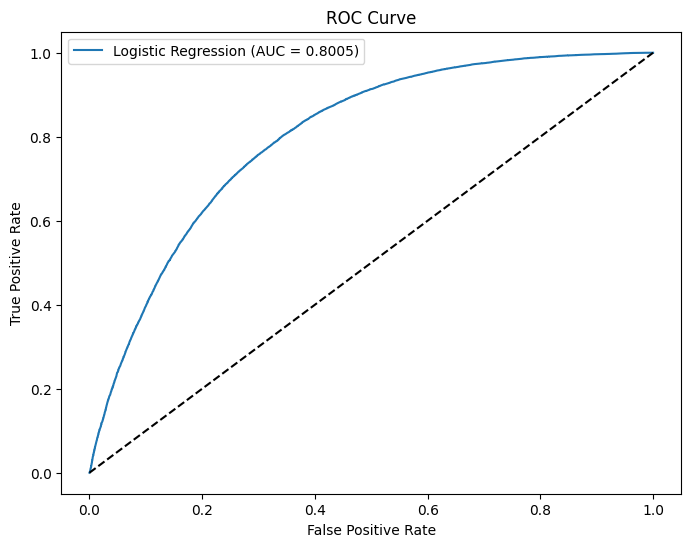

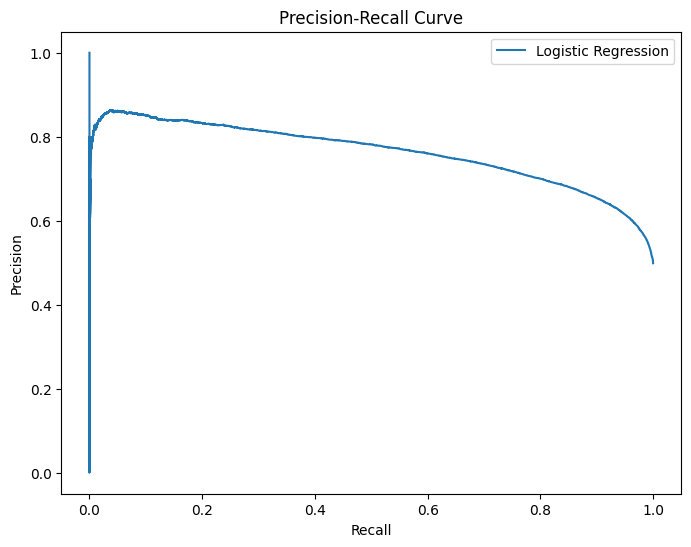

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# create pandas dataframe
df = pd.concat([X, y], axis=1)

# Display first few rows
print("First few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Define features (X) and target (y)
selected_features = [
    'HighBP', 'GenHlth', 'DiffWalk', 'BMI', 'HighChol', 'Age',
    'PhysHlth', 'HeartDiseaseorAttack', 'NoDocbcCost', 'MentHlth'
]
X = df[selected_features]
y = df['Diabetes_binary']

# Generate empirical data to accomodate for imbalanced dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

# Split the original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train the Logistic Regression model based on the best parameters
log_reg = LogisticRegression(
    penalty = 'l2',
    C = 100,
    random_state=42,
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced'
)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()